## Amazon Fine Food Reviews Analysis Truncated SVD

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/final.sqlite" "final.sqlite"

In [7]:
import os
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    
print("Preprocessed Amzon fine food data columns  shape : ",final.shape)
print("fPreprocessed Amzon fine food data columns       :",final.columns.values)

Preprocessed Amzon fine food data columns  shape :  (364171, 12)
fPreprocessed Amzon fine food data columns       : ['index' 'Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text' 'CleanedText']


In [8]:
preprocessed=final['CleanedText'][:100000]
len(preprocessed)

100000

## TFIDF Vectorization

In [9]:
tf_idf_vect = TfidfVectorizer(min_df=10,max_df=0.9,max_features=2000)
tf_idf_vect.fit(preprocessed)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['abl', 'about', 'abov', 'absolut', 'absorb', 'accept', 'accord', 'acid', 'acquir', 'across']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (100000, 2000)
the number of unique words including both unigrams and bigrams  2000


## Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.

In [10]:
indices = np.argsort(tf_idf_vect.idf_)[::-1]
features = tf_idf_vect.get_feature_names()

top_features = [features[i] for i in indices[:3000]]
print(top_features)



['tunnel', 'matcha', 'anchovi', 'lobster', 'gopher', 'flea', 'goji', 'pellet', 'evo', 'darjeel', 'film', 'xylitol', 'chipotl', 'couscous', 'aerogarden', 'fenugreek', 'bulli', 'lavend', 'clam', 'bpa', 'rooibo', 'goat', 'coke', 'jug', 'pine', 'refri', 'purina', 'pear', 'ketchup', 'ring', 'cough', 'seawe', 'canida', 'dye', 'felin', 'bergamot', 'muesli', 'pearl', 'everlast', 'tablet', 'infect', 'rabbit', 'rum', 'oreo', 'hemp', 'wasabi', 'cancer', 'cola', 'pineappl', 'eden', 'balsam', 'moth', 'princ', 'king', 'mate', 'cooker', 'mrs', 'cashew', 'malt', 'jalapeno', 'cramp', 'tinkyada', 'pig', 'greeni', 'numi', 'spearmint', 'quart', 'decaffein', 'leg', 'british', 'apricot', 'jim', 'larabar', 'greek', 'royal', 'fudg', 'valley', 'kashi', 'pastri', 'japan', 'hip', 'hotter', 'rancid', 'miso', 'catnip', 'leak', 'death', 'european', 'stain', 'dirt', 'win', 'alcohol', 'hummus', 'flaxse', 'zuke', 'infus', 'newman', 'belli', 'calcium', 'passion', 'tray', 'oolong', 'corner', 'recipi', 'dispens', 'net', 

## co-occurrence matrix from top 3000 features with neighbour = 5

In [11]:
n_neighbor = 5
occ_matrix = np.zeros((3000,3000))
for row in tqdm(preprocessed):
    words_in_row = row.split()
    for index,word in enumerate(words_in_row):
        if(word in top_features):
            for j in range(max(index-n_neighbor,0),min(index+n_neighbor,len(words_in_row)-1) + 1):
                if(words_in_row[j] in top_features):
                    occ_matrix[top_features.index(word),top_features.index(words_in_row[j])] += 1
                else:
                    pass
        else:
            pass

100%|██████████| 100000/100000 [1:17:26<00:00, 21.52it/s]


In [0]:
np.count_nonzero(occ_matrix)
#occ_matrix.size


2128096

## TrunctedSVD with n_components 1000 for finding maximum varience to compute n_components

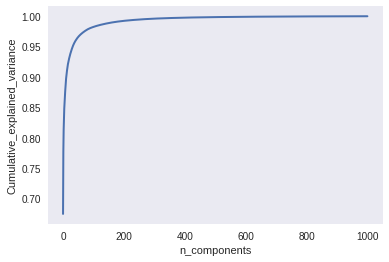

In [0]:

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
tsvd = TruncatedSVD(n_components = 1000)
svd = tsvd.fit_transform(occ_matrix)

percentage_var_explained = tsvd.explained_variance_ / np.sum(tsvd.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)
plt.figure(figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()

plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

## we got optimal n_componets 100 from the maximum cummlative  varience from Above graph

## so from n_components  100 find SVD 

In [0]:
tsvd = TruncatedSVD(n_components = 100)
svd = tsvd.fit_transform(occ_matrix)

In [0]:
svd.shape

(3000, 100)

## Kmeans Clustering on SVD Data

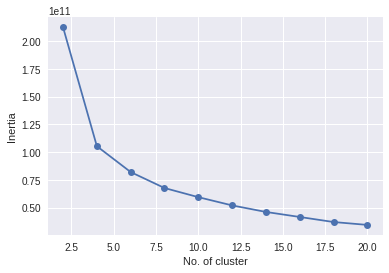

In [0]:
clusters = [2,4,6,8,10,12,14,16,18,20]
from sklearn.cluster import KMeans
dic = {}
for i in clusters:
    clus = KMeans(n_clusters = i)
    clus.fit(svd)
    dic[i] = clus.inertia_
    
plt.plot(list(dic.keys()), list(dic.values()),'-o')
plt.xlabel("No. of cluster")
plt.ylabel("Inertia")
plt.show()


#### taken Optimal Cluster as 7

In [0]:

optimal_k = KMeans(n_clusters = 10)
p = optimal_k.fit_predict(svd)

In [0]:
from collections import Counter
a=optimal_k.labels_
type(a)
Counter(a.tolist())

## Printing WordClouds for each Cluster

Cluster 0:Word Cloud for KMeans Cluster: 0


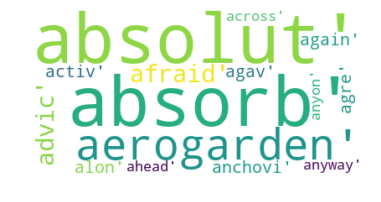

Cluster 1:Word Cloud for KMeans Cluster: 1


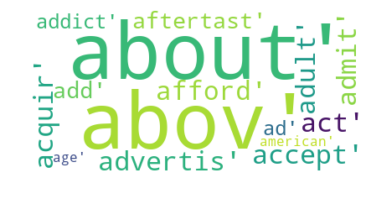

Cluster 2:Word Cloud for KMeans Cluster: 2


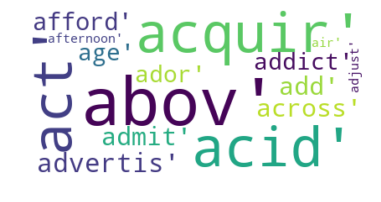

Cluster 3:Word Cloud for KMeans Cluster: 3


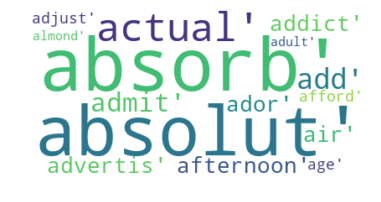

Cluster 4:Word Cloud for KMeans Cluster: 4


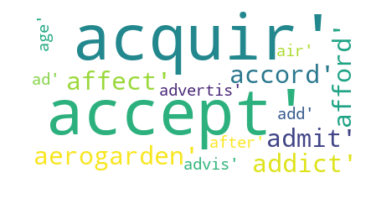

Cluster 5:Word Cloud for KMeans Cluster: 5


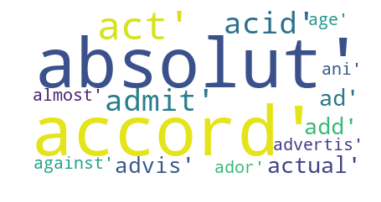

Cluster 6:Word Cloud for KMeans Cluster: 6


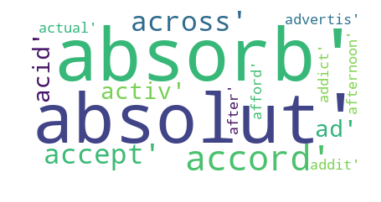

Cluster 7:Word Cloud for KMeans Cluster: 7


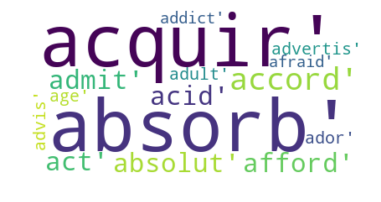

Cluster 8:Word Cloud for KMeans Cluster: 8


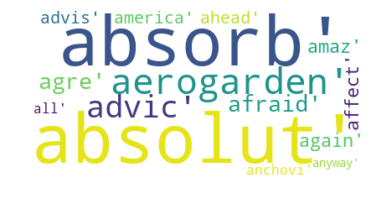

Cluster 9:Word Cloud for KMeans Cluster: 9


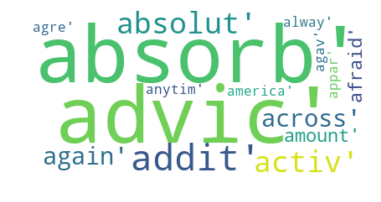

In [0]:
from wordcloud import WordCloud, STOPWORDS

stopwords_t = set(STOPWORDS)

centroids = optimal_k.cluster_centers_.argsort() # function for printing top 30 feature names with each cluster

terms = tf_idf_vect.get_feature_names()

list1 = []

for i in range(10):
    print("Cluster %d:" % i, end='')
    for j in centroids[i, :15]:
        list1.append(terms[j])
    wc = WordCloud(background_color="white", max_words=len(str(list1)), stopwords=stopwords_t)
    wc.generate(str(list1))
    print("Word Cloud for KMeans Cluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    list1.clear()

##  function that takes a word and returns the most similar words using cosine similarity between the vectors

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
def similar_word_10(word):
    similarity = cosine_similarity(occ_matrix)
    word_vect = similarity[top_features.index(word)]
    print("Similar Word to",word)
    index = word_vect.argsort()[::-1][1:11]
    for j in range(len(index)):
        print((j+1),"Word",top_features[index[j]] ,"is similar to",word,"\n")

In [0]:
similar_word_10(top_features[150])

Similar Word to nurs
1 Word and is similar to nurs 

2 Word pump is similar to nurs 

3 Word the is similar to nurs 

4 Word eas is similar to nurs 

5 Word for is similar to nurs 

6 Word babi is similar to nurs 

7 Word both is similar to nurs 

8 Word mother is similar to nurs 

9 Word relax is similar to nurs 

10 Word aroma is similar to nurs 

